In [47]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [48]:
DATA_DIR = 'data'

In [49]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [50]:
import os

train_ds = ImageFolder(
    DATA_DIR,
    transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [51]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [52]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [53]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

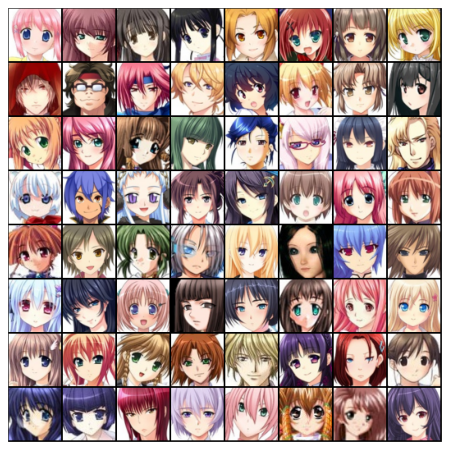

In [54]:
show_batch(train_dl)

In [55]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [57]:
train_dl = DeviceDataLoader(train_dl, device)

In [58]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [59]:
discriminator = to_device(discriminator, device)

In [60]:
latent_size = 128

In [70]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


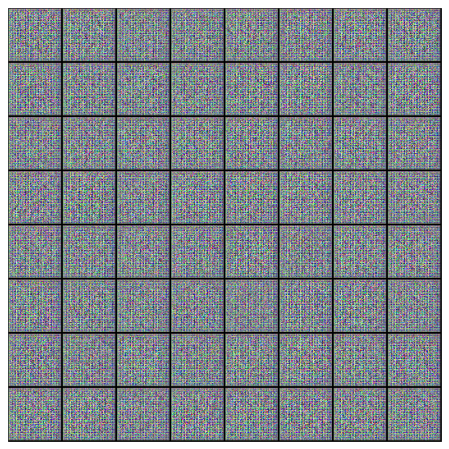

In [71]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# torch.Size([128, 3, 128, 128])

In [73]:
generator = to_device(generator, device)

In [75]:
sample_dir = 'generated_3'
os.makedirs(sample_dir, exist_ok=True)

In [76]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [77]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [78]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch % 5 == 0:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [79]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [80]:
lr = 0.0002
epochs = 16

history = fit(model, criterion, epochs, lr)
save_samples(epochs, fixed_latent, show=False)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/16], loss_g: 7.5332, loss_d: 0.3059, real_score: 0.9163, fake_score: 0.0863
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/16], loss_g: 7.7854, loss_d: 0.3225, real_score: 0.9039, fake_score: 0.0946


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/16], loss_g: 8.1189, loss_d: 0.2597, real_score: 0.9134, fake_score: 0.0847


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/16], loss_g: 8.2359, loss_d: 0.2569, real_score: 0.9191, fake_score: 0.0805


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/16], loss_g: 8.3834, loss_d: 0.1748, real_score: 0.9399, fake_score: 0.0590


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/16], loss_g: 8.6169, loss_d: 0.1218, real_score: 0.9560, fake_score: 0.0432
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/16], loss_g: 9.1655, loss_d: 0.1310, real_score: 0.9580, fake_score: 0.0414


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/16], loss_g: 9.1168, loss_d: 0.1622, real_score: 0.9525, fake_score: 0.0473


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/16], loss_g: 9.0863, loss_d: 0.0754, real_score: 0.9711, fake_score: 0.0284


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/16], loss_g: 9.4902, loss_d: 0.1290, real_score: 0.9645, fake_score: 0.0355


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/16], loss_g: 9.8697, loss_d: 0.1298, real_score: 0.9638, fake_score: 0.0363
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/16], loss_g: 9.7818, loss_d: 0.0736, real_score: 0.9741, fake_score: 0.0255


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/16], loss_g: 9.4261, loss_d: 0.0816, real_score: 0.9735, fake_score: 0.0259


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/16], loss_g: 10.4975, loss_d: 0.1246, real_score: 0.9699, fake_score: 0.0306


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/16], loss_g: 9.7208, loss_d: 0.1047, real_score: 0.9732, fake_score: 0.0260


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/16], loss_g: 9.0664, loss_d: 0.0487, real_score: 0.9824, fake_score: 0.0168
Saving generated-images-0016.png
Saving generated-images-0016.png


In [81]:
losses_g, losses_d, real_scores, fake_scores = history

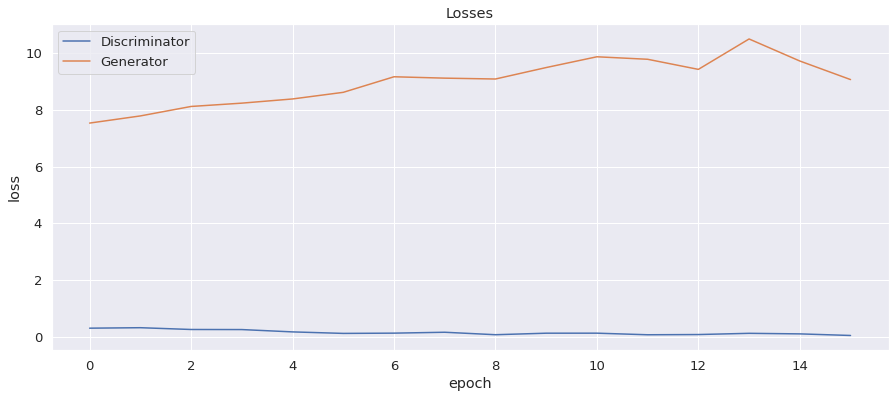

In [82]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');